# Pulse-level control: programming efficient quantum logic gates

# Optimal Control Library
### This notebook demonstrates the workflow for how to use optimal control on QuDIT. help(function) is available. 
Latest update: 1/12/2023, Yujin Cho (cho25@llnl.gov)
Latest update: 4/02/2024, Stefanie Guenther (guenther5@llnl.gov)

***
## Workflow: 
<font size="4"> [Generate a pulse for a target unitary](#1.-Generate-a-pulse-for-a-target-unitary) &#9658; [Load the pulse to config](#2.-Load-the-pulse-to-config) &#9658; [Generate a classifier and a confusion matrix](#Generate-a-classifier-and-a-confusion-matrix-[Optional]) \
&#9658; [ [Check the time evolution of the gate](#3.-Time-evolution-of-a-gate) &#9659; [Perform amplitude optimization](#4.-Amplitude-optimization) &#9659; [Check the gate repetitions](#5.-Apply-a-gate-repeatedly) ] * $n$ times, potentially for different weights for the spectral filer.

Pulses can be generated with either the TensorFlow Optimal Control library, or with Quandary, see below. You can also upload your own pulse. Note that pulses are given in the rotating frame for p and q (I and Q) in units MHz. The OPX requires the pulse length to be an integer multiple of 4ns, as well as a sampling rate of one point per ns. Hence, generated pulses should be downsampled accordingly. 

When uploading the pulse to the device configuration, there are two parameters that can be tuned in order to calibrate the pulses. One is a constant scaling factor that is applied to the amplitude of the control pulses  and the other one is a weighting factor for the spectral filter that weights the scaling between the 01 and the 12 frequencies. While four methods to tune the former (amplitude optimization) are described below in this notebook, the latter (spectral filter weights) should be adjusted by hand within an outer loop (not demonstrated here, instead we here choose a fixed spectral filter weight of 1.6). 

Two ways to investigate the performance of the pulses are presented below: One is to plot the time evolution of the state while playing the gate, where portions of the gate are played up to discrete time-steps where measurements are taken. This allows you analyze the predicted vs the measured state evolution over time. The other one is to play the gate multiple times behind each other (gate repetitions) where measurements are taken after each gate application. Here one compares the state population measurement after each gate application to the predicted ones. Predicted evolutions are computed via mesolve. 

### [Amplitude optimization methods](#Amplitude-Optimization)
  The goal is to scale the control pulse amplitudes with a constant factor so that the measured (potentially corrected) outcome is closest to the predicted outcome (as computed from mesolve). There are four ways to find an optimal scaling factor for the amplitude:
- [Amplitude sweep](#Amplitude-Sweep): Plays the gate multiple times for various amplitude scaling factors. Compare the expected population of the target state with the measured one. Measurements are only taken at the final time after playing the pulse.
- [Using time evolution](#Using-time-evolution): Finds the amplitude factor that minimize the time-integral over the difference between the measured population and the expected target population. This is rather time-consuming, because portions of the gate are played many times, taking measurments every 4ns. You will need to know the target state population for this method to work.  
- [Using gate repetition](#Using-gate-repetition): Similar to the time evolution method, however here the gate is repeated multiple times behind each other in order to amplify the error. This is even slower. 
- [OPX binary search](#OPX-binary-search): Similar to amplitude sweep, but here the amplitude sweep is performed within the OPX environment, which makes it faster.

***

## Load the libraries

In [1]:
%load_ext autoreload
%autoreload 2 

from OC_load_libraries import *
from calibration_config_TANT import calTantalum

2025-08-11 09:09:46,470 - qm - INFO     - Starting session: 69f2cdcc-6ab5-4ecf-9aa1-759033a7184b
XDb import failed


In [2]:
import opx_config_TANT_opx1 as cf
config = cf.config

## Get transition frequencies from the device and copy f01 and f12 into the quandary script

In [3]:
# get device transition frequencies
print("Frequencies [MHz]: LO01 =", cf.lo_andrew01*1e-6, "IF01 =", cf.if_andrew01*1e-6)
print("Frequencies [MHz]: LO12 =", cf.lo_andrew12*1e-6, "IF12 =", cf.if_andrew12*1e-6) 
f01 = cf.if_andrew01 + cf.lo_andrew01
f12 = cf.if_andrew12 + cf.lo_andrew12
print("Transition frequencies [GHz]: f01 =", f01*1e-9, "f12=", f12*1e-9)

Frequencies [MHz]: LO01 = 3400.0 IF01 = 16.634567
Frequencies [MHz]: LO12 = 3400.0 IF12 = -192.528753
Transition frequencies [GHz]: f01 = 3.416634567 f12= 3.2074712470000004


### Example usage of Quandary to optimize for a SWAP 02 gate ###

unitary = [[0,0,1],[0,1,0],[1,0,0]] # Target unitary gate, here SWAP02
pulse_length = 240.0  # ns

# Optionally, set bounds on the control pulse amplitudes in rotational frame [MHz]
maxctrl_MHz = 4.0  # MHz

# Prepare Quandary configuration. 
quandary = Quandary(targetgate=unitary, T=pulse_length, maxctrl_MHz=maxctrl_MHz, tol_infidelity=1e-4)

# Execute quandary. Default number of executing cores is the essential Hilbert space dimension (here 3).
t, p, q, infidelity, expectedEnergy, population = quandary.optimize()
print(f"\nOptimized Fidelity = {1.0 - infidelity}")

# Plot the results
plot_results(quandary, p, q, expectedEnergy, population)

To uploade the pulse, it should be sampled at a rate of 64 points per ns. To do this, re-evaluate the optimized pulses given the optimized B-spline paramters (stored in 'quandary_config.popt' after 'quandary_run' had been called.

'evalControls(quandary_config, pcof0=<optimized_bspline_coeffs>, points_per_ns=<your_samplerate>)'

**Named arguments**:
>> * **pcof0** (list) : (optimized) Bspline coefficients that determine the control pulse that is to be evaluated. E.g. use the optimized coefficients in 'quandary_config.popt'
>> * **points_per_ns** (Int) : your sample rate (number of points per ns)

> Return:
>> * **t** (list) : Discrete time points with this specific sample rate
>> * **p,q** (lists) : Pulses in MHz evaluated at each time point for this sample rate


# Sanity check: Plot the time evolution using mesolve, starting from initial ground state. This plot should look a lot like the plot in the lower left corner of the above figure (population from |0>)
nstates = 4
starting = 0

Htot = generate_Hamiltonian(nstates)
xpath, ypath = np.array(p1), np.array(q1)
samplerate = 64
t = np.arange(0, len(xpath), 1)/samplerate

concat_pulse = np.stack((xpath,ypath), axis=-1) *2*np.pi*1e-3
prob_me_time, prob_me_gate, numgate = qt_mesolve(Htot, nstates, starting, concat_pulse, t, cop=True)

fig, ax = plt.subplots()
for i in range(3):
ax.plot(t, prob_me_time[i].real, '--', label=str(i))
ax.grid()
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Population') 


# 2. Load the pulse to device configuration
NOTE: The remainder of this notebook has not been tested on the new chip. 


This function loads the pulse to the device configuration. The 'scale' argument can be passed to scale the pulses amplitudes, and this is the factor that we will optimize below in section 4 [Amplitude optimization]. The 'sf_weight' is used in the spectral filter to weight 01 and 12 transition. In this notebook, it is fixed to 1.6, but in principle this should also be optimized for. 

- `upload_pulse(config, element, name_short, pulse_info=['','',32], scale=None, plot=True, spectral_filter=False, sf_weight=2.1, method='reduction', ftype='fir')`\
This function is implemented in 'gate_calibration_library.py'

> required arguments:
>> config: configuration file that you want the pulses to be saved.\
>> element: 'andrew01' is for qubit 0-1 frame.\
>> name_short: your pulse name\
>> pulse_info = [xpath, ypath, downsamp]:\
  -> xpath, ypath : I and Q pulses (p and q). Compatible formats: list, array, file path \
  -> downsamp (optional): Number of data points per ns. This should match the sample rate of the generated pulse.

> optional argument:
>> downsamp = 32 (default)\
>> scale = None -- if None, it calculates area ratio between TF-generated X gate and pi_op_andrew01 and use it as a scale factor. You can give any factor you want.\
>> spectral_filter = False (default)\
>> sf_weight = 2 -- weight between 01 and 12 transition. default is 2.1 

> return
>> config file   

***
- Output
- first plot: spectral filter
- second plot: uploaded pulse (first panel: original pusle, second: calibrated pulse (OPX unit), third: FFT)


In [4]:
file_path = r"/home/petersson1/quandary_data_dir"
# fname = ["//p_ctrl.dat", "//q_ctrl.dat"]
fname = ["//p_ctrl_scaled.dat", "//q_ctrl_scaled.dat"]

with open(file_path+fname[0], 'r') as f:
    p = f.readlines()

with open(file_path+fname[1], 'r') as f:
    q = f.readlines()
G2M = 1e3
pp = np.array([G2M*float(pval.replace('\n','')) for pval in p])
qq = np.array([G2M*float(qval.replace('\n','')) for qval in q])

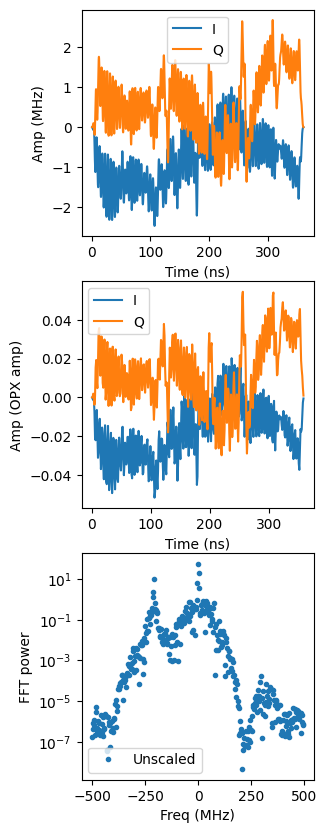

In [5]:
xpath, ypath = pp, qq # sign of q-pulse appears correct
name_short = 'swap02'
name_op = name_short + '_op'
downsamp = 64  # Pulses p and q are given at 64 points per nano second, now downsample so that sample rate is ONE point per ns for OPX
pulse_info = [xpath, ypath, downsamp] ## needed afterwards for ME solve

#config=upload_pulse(config, 'andrew01', name_short, pulse_info, scale=None, spectral_filter = True, sf_weight=1.6)

# no spectral filter
config=upload_pulse(config, 'andrew01', name_short, pulse_info, scale=None, spectral_filter = False)

In [6]:
# Check that the pulse is uploaded correctly. You should see the gate name at the end.
config['elements']['andrew01']

{'mixInputs': {'I': ('con1', 3),
  'Q': ('con1', 4),
  'lo_frequency': 3400000000,
  'mixer': 'gimlet'},
 'intermediate_frequency': 16634567,
 'operations': {'pi_op_andrew01': 'pi_pulse_andrew01',
  'piY_op_andrew01': 'piY_pulse_andrew01',
  'pi_gauss_op_andrew01': 'pi_gauss_pulse_andrew01',
  'Rx_pi2_op': 'Rx_pi2_pulse',
  'Ry_pi2_op': 'Ry_pi2_pulse',
  'Rx_pi2n_op': 'Rx_pi2n_pulse',
  'Ry_pi2n_op': 'Ry_pi2n_pulse',
  'Rx_pi_op': 'Rx_pi_pulse',
  'Ry_pi_op': 'Ry_pi_pulse',
  'Rx12_pi2_modulated_op': 'Rx12_pi2_modulated_pulse',
  'Ry12_pi2_modulated_op': 'Ry12_pi2_modulated_pulse',
  'Rx12_pi2n_modulated_op': 'Rx12_pi2n_modulated_pulse',
  'Ry12_pi2n_modulated_op': 'Ry12_pi2n_modulated_pulse',
  'swap02_op': 'swap02_pulse'}}

## Generate a classifier and a confusion matrix [Optional]
Probe the current system quality by investigating the confusion matrix. If all the diagonal elements are over 0.95, it is considered good. If not, you might want to reach out so that we can re-calibrate the device. The confusion matrix will be used further below to plot some results. 



<<< Current queue for resources: >>>
Controller con1
  analog outputs [1, 2, 3, 4]
  analog inputs [1]
  digital outputs [3]
-----------------------------------------------------------------------------------------------
Start                    User                     UUID
-----------------------------------------------------------------------------------------------
[20250811]09:10:34       Anders                   adc4154e-067b-43a2-ab30-48e7653a4a5b



You are done waiting.

device: TCPIP0::192.168.1.103::10000::SOCKET
2025-08-11 09:10:34,952 - qm - INFO     - Performing health check
2025-08-11 09:10:34,957 - qm - INFO     - Health check passed
TCPIPSocket at TCPIP0::192.168.1.103::10000::SOCKET
device: TCPIP0::192.168.1.103::10000::SOCKET
IDN: Tabor Electronics,LS1294R,2233063,03092023
INST? CH1
Power setpoint; -7.180
setting Channel 1 to ON
Output? ON
INST? CH1
Frequency setpoint; 7855600000.000
setting Channel 1 to ON
Output? ON
2025-08-11 09:10:41,245 - qm - INFO     - Sendi

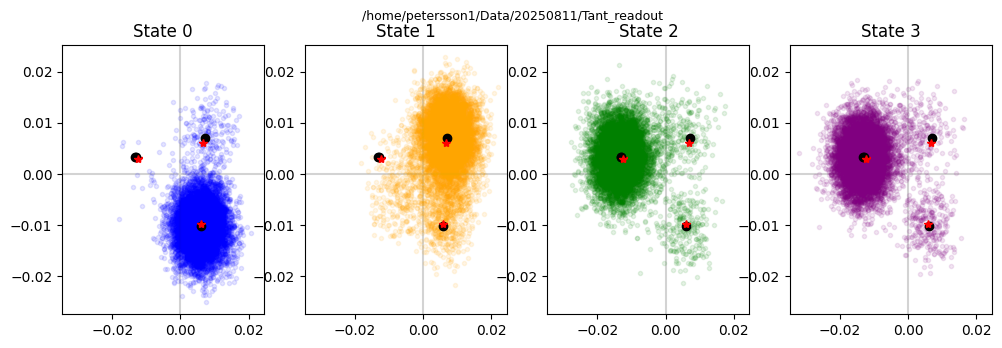

clf_means:
[[ 0.57583569 -1.00269185]
 [ 0.71067019  0.78733464]
 [-1.32735782  0.31539207]]

Median centroids:
[[ 0.59537198 -1.0105053 ]
 [ 0.70900023  0.70378985]
 [-1.31774936  0.32845885]]
>>>>>>>>>>>>> PLACEHOLDER FOR UPDATING DB <<<<<<<<<<<<<<
  [[ 0.57583569 -1.00269185]
 [ 0.71067019  0.78733464]
 [-1.32735782  0.31539207]] at QPUs.Tant.andrew.clfmeans (automatic)
>>>>>>>>>>>>>                             <<<<<<<<<<<<<<
>>>>>>>>>>>>> PLACEHOLDER FOR UPDATING DB <<<<<<<<<<<<<<
  [[0.965375 0.03175  0.002875]
 [0.1045   0.862875 0.032625]
 [0.026875 0.033875 0.93925 ]] at QPUs.Tant.andrew.confusionmatrix (automatic)
>>>>>>>>>>>>>                             <<<<<<<<<<<<<<

Confusion matrix:
[[0.965375 0.03175  0.002875]
 [0.1045   0.862875 0.032625]
 [0.026875 0.033875 0.93925 ]]


In [7]:
user = 'Anders'
c = calTantalum(user, automatic = True)
[clf, cmat] = c.characterize_readout(Navg = 1e4)

# 3. Investigate the time evolution of the gate, for a given amplitude factor
***
This function plays a portion of your pulse to visualize the state evolution while playing a gate. Measurements are taken at discrete time steps every 4ns, starting from 16 ns to your pulse length. 
- `time_evolution(config, username, gate_op, amp, starting, Nshots, tstep)` (measurement):

> arguments:
>> config: configuration file that contains your pulse \
>> username: your name that appears in the queue\
>> gate_op: [your operation name, element name]

> optional:
>> amp = 1 (default). --> pulse * q.amp(amp)\
>> starting = 0 (default) --> initial state. 0, 1, or 2\
>> Nshots = 1000 (default) --> number of shots\
>> tstep = 4 (default) --> time step 1ns (in the code, truncate = tstep/4)

> return: 
>> Ntsteps (time array), path (file name)

***
This function plots the measured time evolution as well as the expected one, computed from mesolve.
- `plot_time_evolution(path, starting, Nshots, Nsteps, clf)`

> arguments:
>> path: the file path of the measured data (returned value from `time_evolution`)\
>> starting: initial state\
>> Nshots: number of shots\
>> Nsteps: number of time steps (returned value from `time_evolution`)

> optional:
>> clf: classifier. default: None (pulling from the latest measurement) \
>> correction: confusion matrix.

> return:
>> diff: difference between the measured data without the correction and the ME solve. 

In [8]:
initialState=0
Nshots=1000

# experimenting with the amp parameter, default: amp=1
amp=0.85
Nsteps, path = time_evolution(config, user, gate_op=[name_op, 'andrew01'], amp=amp, starting=initialState, Nshots=Nshots, tstep=4)
clear_output(wait=True)



<<< Current queue for resources: >>>
Controller con1
  analog outputs [1, 2, 3, 4]
  analog inputs [1]
  digital outputs [3]
-----------------------------------------------------------------------------------------------
Start                    User                     UUID
-----------------------------------------------------------------------------------------------
[20250811]09:11:40       Anders                   a7e6d338-7327-4944-8bff-97f465a0c1f2



You are done waiting.

device: TCPIP0::192.168.1.103::10000::SOCKET
2025-08-11 09:11:41,023 - qm - INFO     - Performing health check
2025-08-11 09:11:41,028 - qm - INFO     - Health check passed
IDN: Tabor Electronics,LS1294R,2233063,03092023
INST? CH4
Frequency setpoint; 7200000000.000
setting Channel 4 to ON
Output? ON
INST? CH4
Power setpoint; 18.000
setting Channel 4 to ON
Output? ON
INST? CH3
Frequency setpoint; 3400000000.000
setting Channel 3 to ON
Output? ON
INST? CH3
Power setpoint; 18.000
setting Channel 3 to ON
Output?

In [9]:
len(Nsteps)

87

XDb import failed
Check T1 and T2 values


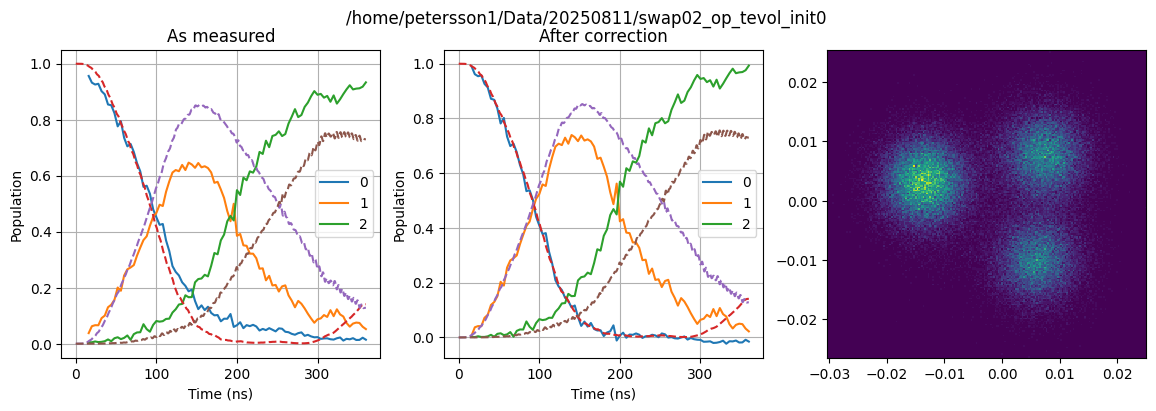

||diff|| =  2.4665448429450136
p_avg array shape: (87, 3)


In [10]:
# Note: path holds the path to the hdf5 file that time_evolution() returned
diff, p_avg, p_avg_c = plot_time_evolution(path, initialState, Nshots, Nsteps, clf=clf, mesolve=[True, pulse_info], correction=inv(cmat))

print("||diff|| = ", np.linalg.norm(diff))
print("p_avg array shape:", p_avg.shape)

# save data on file
file_path = r"/home/petersson1/Data/20250804_"+str(initialState)+r"_"
fname =["pop_raw.dat", "pop_cor.dat"]

np.savetxt(file_path+fname[0], p_avg, fmt='%.18e', delimiter=' ')
np.savetxt(file_path+fname[1], p_avg_c, fmt='%.18e', delimiter=' ')

# First experiment: initial state |0>

XDb import failed
Check T1 and T2 values


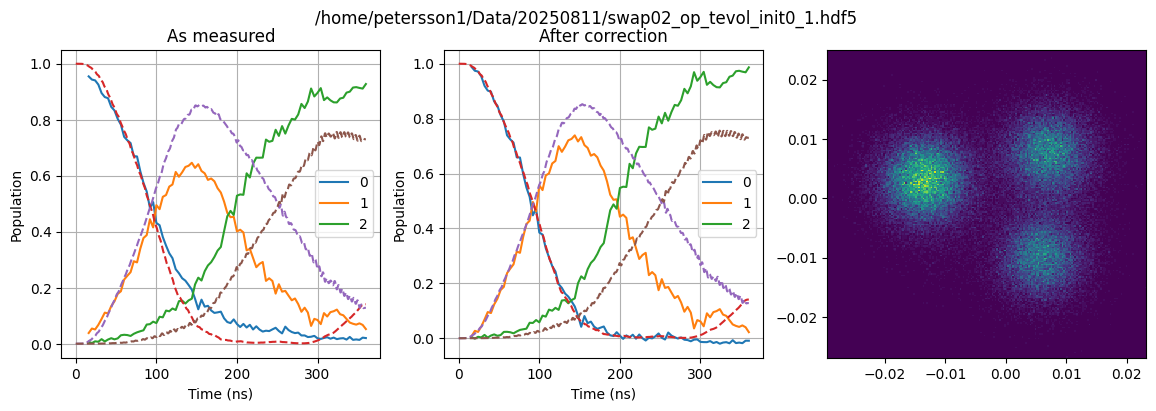

||diff|| =  2.496548967159998


In [11]:
initialState=0

Nsteps, path = time_evolution(config, user, gate_op=[name_op, 'andrew01'], amp=amp, starting=initialState, Nshots=Nshots, tstep=4)
clear_output(wait=True)
diff, p_avg, p_avg_c = plot_time_evolution(path, initialState, Nshots, Nsteps, clf=clf, mesolve=[True, pulse_info], correction=inv(cmat))

print("||diff|| = ", np.linalg.norm(diff))
# save population data on file
file_path = r"/home/petersson1/Data/Scaled/init_"+str(initialState)+r"_"
fname =["pop_raw.dat", "pop_cor.dat"]

np.savetxt(file_path+fname[0], p_avg, fmt='%.18e', delimiter=' ')
np.savetxt(file_path+fname[1], p_avg_c, fmt='%.18e', delimiter=' ')

# Second experiment, initial state |1>

XDb import failed
Check T1 and T2 values


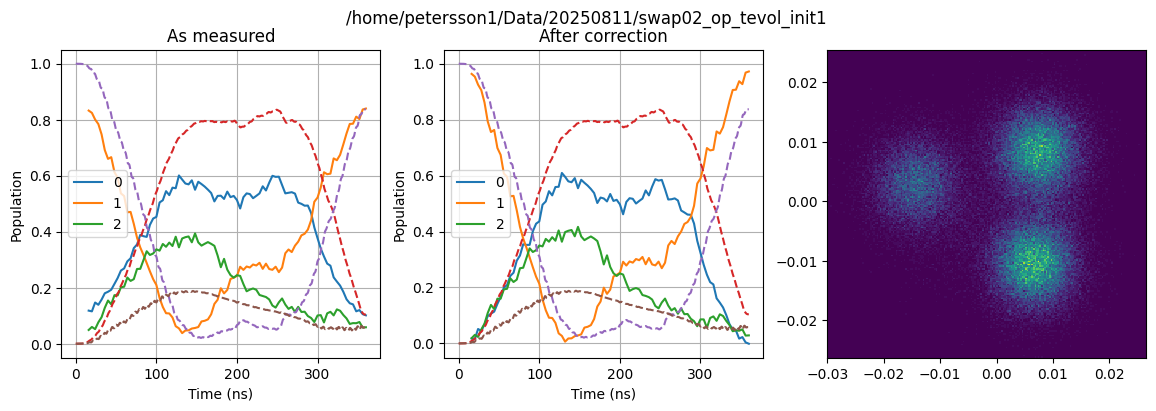

||diff|| =  2.595127924873833


In [12]:
initialState=1 # starting from |1>

Nsteps, path = time_evolution(config, user, gate_op=[name_op, 'andrew01'], amp=amp, starting=initialState, Nshots=Nshots, tstep=4)
clear_output(wait=True)
diff, p_avg, p_avg_c = plot_time_evolution(path, initialState, Nshots, Nsteps, clf=clf, mesolve=[True, pulse_info], correction=inv(cmat))

print("||diff|| = ", np.linalg.norm(diff))
# save population data on file
file_path = r"/home/petersson1/Data/Scaled/init_"+str(initialState)+r"_"
fname =["pop_raw.dat", "pop_cor.dat"]

np.savetxt(file_path+fname[0], p_avg, fmt='%.18e', delimiter=' ')
np.savetxt(file_path+fname[1], p_avg_c, fmt='%.18e', delimiter=' ')

# Third experiment: initial state |2>

XDb import failed
Check T1 and T2 values


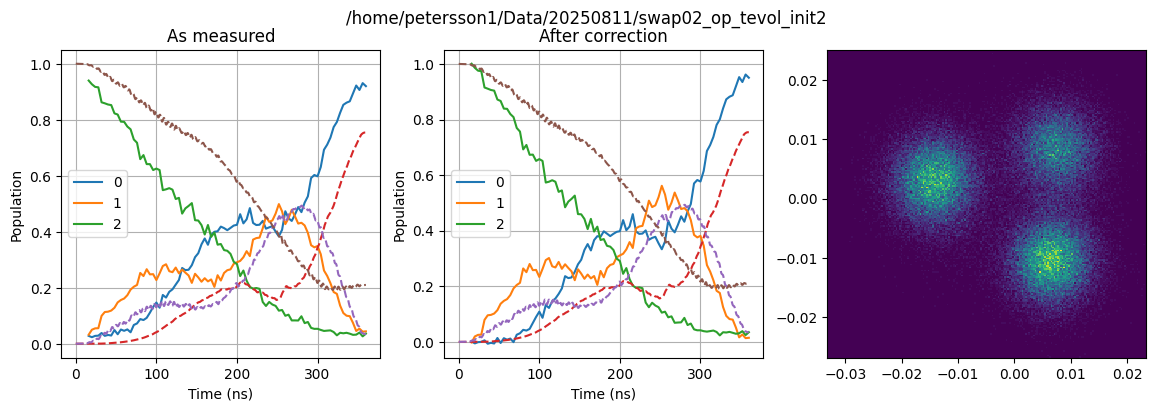

||diff|| =  2.904977995787795


In [13]:
initialState=2 # starting from |2>

Nsteps, path = time_evolution(config, user, gate_op=[name_op, 'andrew01'], amp=amp, starting=initialState, Nshots=Nshots, tstep=4)
clear_output(wait=True)

diff, p_avg, p_avg_c = plot_time_evolution(path, initialState, Nshots, Nsteps, clf=clf, mesolve=[True, pulse_info], correction=inv(cmat))
print("||diff|| = ", np.linalg.norm(diff))

# save population data on file
file_path = r"/home/petersson1/Data/Scaled/init_"+str(initialState)+r"_"
fname =["pop_raw.dat", "pop_cor.dat"]

np.savetxt(file_path+fname[0], p_avg, fmt='%.18e', delimiter=' ')
np.savetxt(file_path+fname[1], p_avg_c, fmt='%.18e', delimiter=' ')

# The following boxes have not been updated

# Inspect data from hdf5 file (update filename)

In [16]:
# NOTE: the file name changes every time the experiment is run
fname = r"/home/petersson1/Data/20250804/swap02_op_tevol_init0_9.hdf5"
from optimal_control_analysis_library import plot_time_evolution

start = 16  # Starting value
stop = 241  # Ending value (inclusive)
step = 4  # Number of elements

tarray = np.arange(start, stop, step)
#plot_time_evolution(fname, starting=0, Nshots=1000, tsteps=np.array([16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56]), clf=clf)
diff = plot_time_evolution(fname, starting=0, Nshots=1000, tsteps=tarray, clf=clf)

ValueError: cannot reshape array of size 87000 into shape (57,1000)

## Extract population data from the hdf5 files and export

## Apply the gate repeatedly, while taking time-evolution measurements
***
Play the gate repeatedly for a given amplitude factor while taking time-evolution measurements. Implemented in 'gate_calibration_library.py'
- `gate_repetition(config, username, gate_op, amplitude, starting, post_op, maxM, Nshots)`

> arguments
>> config: configuration file that contains your pulse\
>> username: your user name\
>> gate_op: [your operation, element]\
>> amplitude: amplitude of the pulse.

> optional:
>> starting: initial states. default: 0\
>> post_op: apply an operator before the measurement (post operators) if needed. default: []\
>> maxM: maximum number of gate repetition. default: 200\
>> Nshots: number of shots. default: 1000

***
Plot the time evolution of the repeated gate time-measurements and compares to the expected ones as computed from mesolve (optional). 
- `plot_gate_ops(path, maxM, Nshots, clf, correction, mesolve, display_num)`

> arguments:
>> path: measured file path. Returned value of `gate_repetition`\
>> maxM: # of gate repetition\
>> Nshots: # of shots\
>> clf: classifier

> optional:
>> correction: confusion matrix or identity if you don't need it.\
>> mesolve: calculates expected changes with mesolve. default: True\
>> display_num: if you want to display only the first few gates. default: None (display all the measured data)

> return:
>> diff: difference between the measured and the mesolve data.

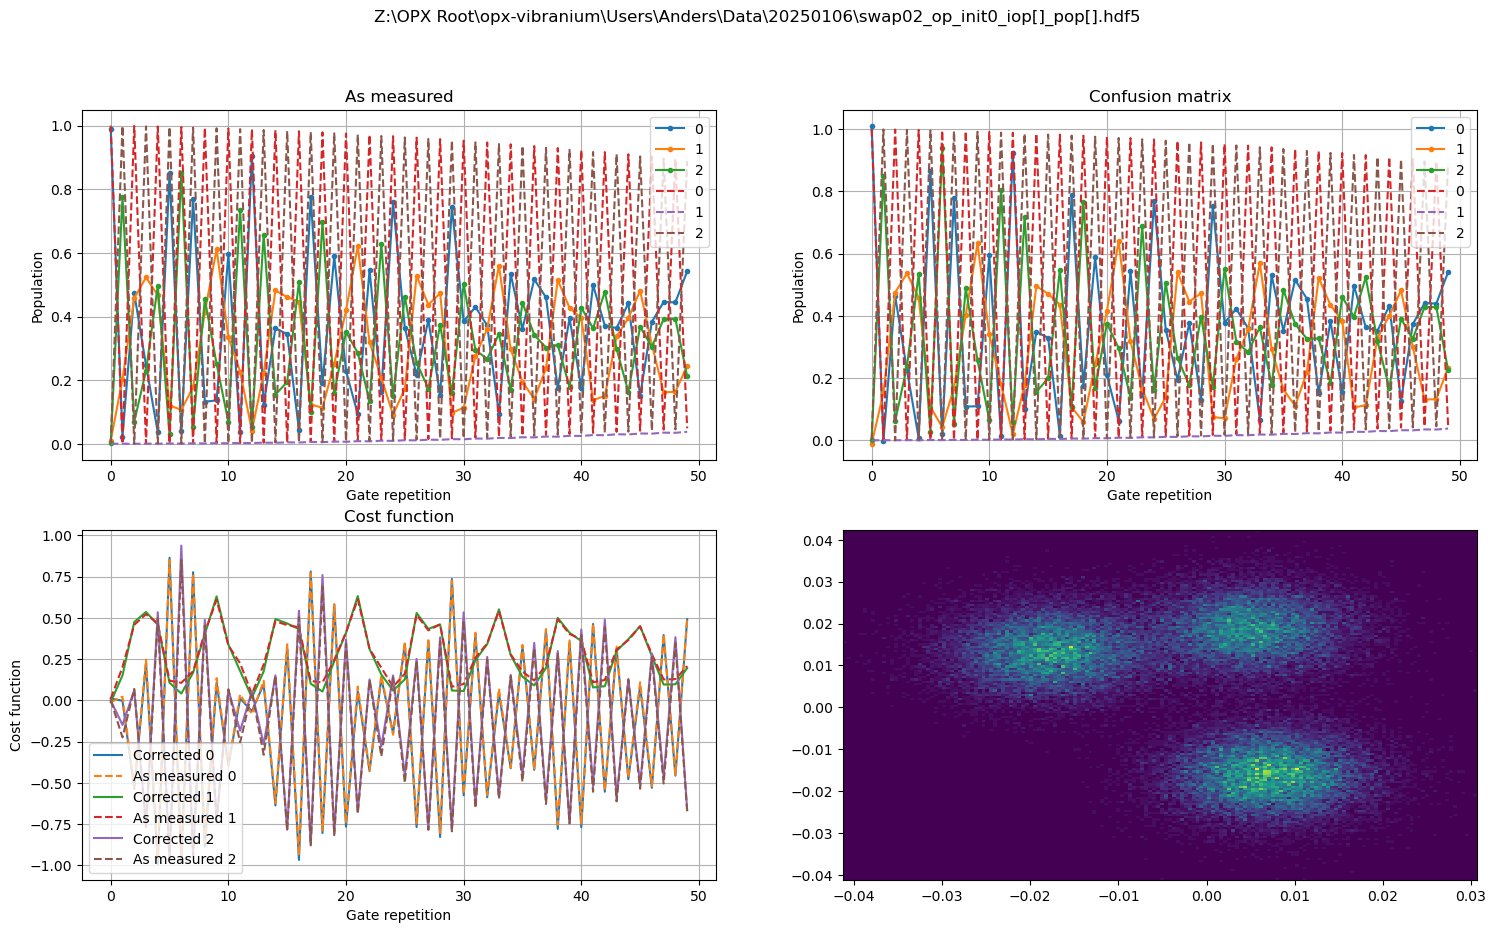

In [10]:
maxM = 50
Nshots = 1000
starting = 0
amp = 1.0
user = 'Anders'

path = gate_repetition(config, user, gate_op=[name_op, 'andrew01'], amplitude=amp, starting=0, post_op=[], maxM=maxM, Nshots=Nshots)
clear_output(wait=True)
diff = plot_gate_ops(path, maxM, Nshots, clf, correction=inv(cmat), mesolve=[True, [starting, *pulse_info]], display_num=None)

# 4. Amplitude optimization
Here you will find the four methods to optimize the amplitude scaling factor

## Amplitude Sweep (method 1)
***
Performs a sweep over a range of amplitude scaling factors while playing the gate. This function is implemented in 'gate_calibration_library.py'. 
- `gate_amp_calibration(config, username, gate_op)`

> arguments:
>> config: configuration file that contains your pulse\
>> username: your username\
>> gate_op = [your operation, element name] 

> optional:
>> starting: initial states. 0 (default)\
>> ampi : initial amplitude. 0.9 (default)\
>> ampf : final amplitude. 1.1 (default) Maximu should be less than 2.\
>> ampstep : amplitude scan step size. 1/2**8 (default)\
>> Nshots : number of shots. 1000 (default)\
>> numgate : number of gates to play. 3 (default) The more your repeat a gate, the more you amplify errors. 

> return: 
>> path

***
Plots the results of the amplitude calibration. This function is implemented in 'optimal_control_analysis_library.py'.
- `plot_amp_calibration(path, ampi, ampf, ampstep, Nshots, clf, target)`

> arguments:
>> path: your file path. return value of `gate_amp_calibration`\
>> ampi: initial amplitude\
>> ampf: final amplitude\
>> ampstep: amplitude step\
>> Nshots: number of shots

> optional:
>> clf: classifier
>> target: [state, target value] if given, it will find the closest amplitude of your target value.

***
&#9658; rule of thumb: begin with broad amplitude range (e.g. 0.2) and coarse ampstep (e.g. 1/2**8) at low num gate(e.g. 1 or 3). Then narrow down the range with finer ampstep and larger numgate.


Analyzing characterization data for multistate readout. 4 states measured, 3 included in GMM.
GMM training model calculated for 1/5 of data. Confusion matrix calculated from remaining 4/5 of data.


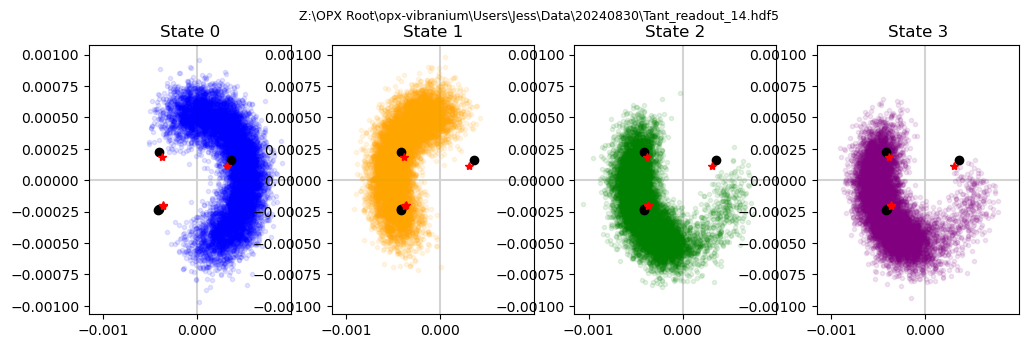

clf_means:
[[ 0.0238859   0.00329138]
 [-0.0364149   0.03379607]
 [-0.04454072 -0.02158798]]

Median centroids:
[[ 0.03576893  0.01640711]
 [-0.04133657  0.02248567]
 [-0.04104767 -0.02303626]]

Confusion matrix:
[[0.90275  0.095125 0.002125]
 [0.068125 0.566375 0.3655  ]
 [0.1405   0.178    0.6815  ]]
min 0: 0.88837890625, max 0: 0.8
min 1: 0.841748046875, max 1: 0.88837890625
min 2: 0.841748046875, max 2: 0.806591796875
Optimized ampltude: 0.806591796875


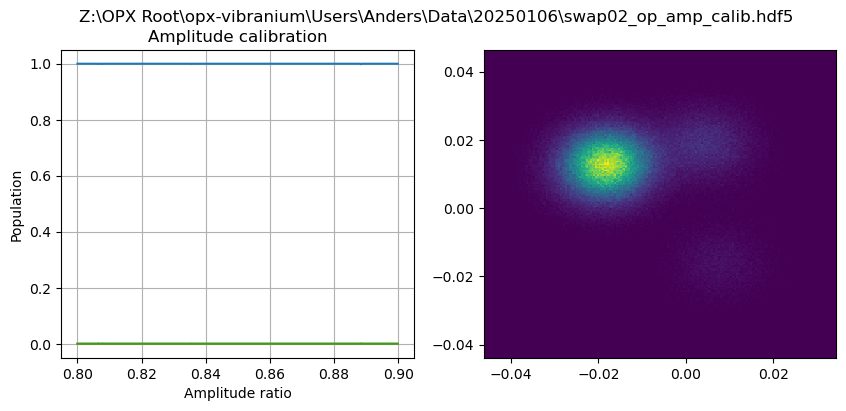

In [11]:
ampi = 0.80
ampf = 0.9
ampstep = 1/2**12
Nshots = 1000
numgate = 3
user = 'Anders'

path = gate_amp_calibration(config, user, gate_op=[name_op, 'andrew01'], starting = 0, ampi=ampi, ampf=ampf, ampstep=ampstep, Nshots=Nshots, numgate=numgate)
clear_output(wait=True) # comment out this line if you want to see the result of the QM job
amp_opt_ampcal = plot_amp_calibration(path, ampi, ampf, ampstep, Nshots, clf=None, target=[2, 1])

In [12]:
print("Optimal amplitude from amplitude sweep: ", amp_opt_ampcal)

Optimal amplitude from amplitude sweep:          min       max
0  0.888379  0.800000
1  0.841748  0.888379
2  0.841748  0.806592
3  0.806592       NaN


## Using time evolution (method 2)
This finds the amplitude factor that minimizes the time-integral of the mismatch between measured and expected populations. Note that this takes time-evolution measurements (playing portions of the gate many times). The expected time evolution is computed with mesolve. This is implemented in 'gate_calibration_library.py'
- `run_optimizer_time(config, username, pulse_info, clf, bound, gate_op, starting, Nshots, delete_file)`

> arguments:
>> config: confugration file that contains your pulse\
>> username: your username\
>> pulse_info: [x, y, downsamp]. This is needed to get ME solve path.

> optional:
>> clf: classifier. default: None (pulling from the latest measurement)\
>> bound: bounds for amplitude scan. default : (0.8, 0.9)\
>> gate_op: [your operation, elements]\
>> starting: initial state. default: 0\
>> Nshots: number of shots. default: 1000\
>> delete_file: delete the actual measurement files and leave only the summary file. default: True

> return:
>> amp_opt: optimized amplitude

In [ ]:
amp_opt_time = run_optimizer_time(config, user, pulse_info, clf=None, bound=(0.78, 0.88), gate_op=[name_op, 'andrew01'], starting=0, Nshots=1000, delete_file=True)

src Z:\OPX Root\opx-common\Libraries


<<< Current queue for resources: >>>
Controller con1
  analog outputs [1, 2, 3, 4]
  analog inputs [1]
  digital outputs [3]
-----------------------------------------------------------------------------------------------
Start                    User                     UUID
-----------------------------------------------------------------------------------------------
[20250106]17:36:59       Anders                   abad1225-3b2f-4365-b9d0-517ae4fc7335



You are done waiting.

device: TCPIP0::169.254.94.8::10000::SOCKET


In [20]:
print("Time-evolution optimal amplitude: ", amp_opt_time)

0.8081310903102012

## Using gate reptition (method 3)

Similar to the time-evolution optimization (method 2), but using multiple gate repetitions to amplity the error. This finds the amplitude scaling factor that minimizes the time-integral of the mismatch between measurement and expected population computed with mesolve, each for multiple gate repetitions. 
- `run_optmizer_gate(config, username, clf, xpath, ypath, downsamp, gate_op)`

> arguments:
>> config: configuration file that contains your pulse
>> username: your user name
>> pulse_info: [xpath, ypath, downsamp] defined earlier

> optional:
>> clf: classifier. default: None (pulling the latest measured classifier)
>> gate_op: [operation, element] gate to optimize
>> starting: initial value. default: 0
>> maxM : # of gates. default: 4
>> Nshots: # of shots. default: 1000
>> bound: amplitude bounds. default: given input $\pm$ 0.1
>> delete_file: delete measured files and leave only the summary file. default: True

> return:
>> amp_gate: optimized amplitude

In [2]:
amp = 0.837678466796875
user = 'Stefanie'
amp_opt_gate = run_optimizer_gate(config, user, pulse_info, clf=clf, gate_op=[name_op, 'andrew01'], starting=0, maxM=30,\
Nshots=1000, bound=(amp-0.1, amp+0.1), delete_file = True)

NameError: name 'pulse_info' is not defined

In [28]:
print("Optimal amplitude from time-evolution of multiple gate repetitions: ", amp_opt_gate)

## OPX binary search (method 4)
This function uses a built-in option in OPX for amplitude optimization. This approach is faster but you need to know what the target value is for optimization.
- `run_optimizer_opx(config, username, gate, starting, post_gates, amp, Nshots, ytarget, DXMAX, DXdepth, Mmin, Mmax, Mstep)

> arguments:
>> config: configuration file that contains your pulse\
>> username: your user name\
>> gate: gate to optimize

> optional:
>> starting: initial states. default: 0\
>> post_gates: apply an operator before measurements. default: []\
>> amp: initial amplitude. default: 1\
>> Nshots: # of shots. default: 1000\
>> ytarget: your target value. default: 1\
>> DXMAX: maximum range of your tuning parameter. default: 1/128\
>> DXdepth: # of repeat. default: 8\
>> Mmin: min # of gate repetition. default: 2\
>> Mmax: max # of gate repetition. default: 20\
>> Mstep: step size of the gate repetition. default: 4

> return:
>> amp_opx : optimized amplitude

In [30]:
path = run_optimizer_opx(config, 'Stefanie', gate=[name_op,'andrew01'],starting=0,post_gates=[],amp=0.837678466796875,Nshots=1000,ytarget=1.0,DXMAX=1./128,DXdepth=8, Mmin = 2, Mmax = 20, Mstep = 4)
amp_opt_opx = plot_optimizer_opx(path)

In [30]:
print("Optimal amplitude from OPX binary search: ", amp_opt_opx)



<<< Current queue for Tant >>>
-----------------------------------------------------------------------------------------------
Start                    User                     UUID
-----------------------------------------------------------------------------------------------
[20230927]14:19:01       Stefanie                 bdb853f4-844c-4545-9678-801f76347b31



You are done waiting.

2023-09-27 14:19:26,434 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2023-09-27 14:19:26,444 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


2023-09-27 14:19:27,533 - qm - INFO     - Sending program to QOP for compilation


INFO:qm.api.frontend_api:Sending program to QOP for compilation


2023-09-27 14:19:27,833 - qm - ERROR    - Unexpected error: Failed to compile job


ERROR:qm.api.frontend_api:Unexpected error: Failed to compile job


2023-09-27 14:19:27,843 - qm - ERROR    - cannot find matching signature for function 'math.div'. Options are: (int, int) -> fixed, (fixed, fixed) -> fixed, (int, int) -> int (@ File "Z:\OPX Root\opx-common\Libraries\gate_calibration_library.py", line 1204: q.assign(dx,dx/2) )


ERROR:qm.api.frontend_api:cannot find matching signature for function 'math.div'. Options are: (int, int) -> fixed, (fixed, fixed) -> fixed, (int, int) -> int (@ File "Z:\OPX Root\opx-common\Libraries\gate_calibration_library.py", line 1204: q.assign(dx,dx/2) )


2023-09-27 14:19:27,843 - qm - ERROR    - Job 1690409090052 failed. Failed to execute program.


ERROR:qm.api.frontend_api:Job 1690409090052 failed. Failed to execute program.



Queue successfully exited.


FailedToAddJobToQueueException: Job 1690409090052 failed. Failed to execute program.

# 5. Check the time evolution and gate repetitions again, now using an optimized amplitude scaling factor

## Time evolution using an optimized amplitude scaling factor

In [26]:
starting=0
Nshots=1000
amp_opt = amp_opt_gate
Nsteps, path = time_evolution(config, 'Stefanie', gate_op=[name_op, 'andrew01'], amp=amp_opt, starting=starting, Nshots=Nshots, tstep=4)
clear_output(wait=True)
diff=plot_time_evolution(path, starting, Nshots, Nsteps, clf, mesolve=[True, pulse_info], correction=inv(cmat))



<<< Current queue for Tant >>>
-----------------------------------------------------------------------------------------------
Start                    User                     UUID
-----------------------------------------------------------------------------------------------
[20230927]14:11:24       Stefanie                 a5b4f90c-dc88-4ce6-91ca-8229a3713561



You are done waiting.

2023-09-27 14:11:49,569 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2023-09-27 14:11:49,569 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


2023-09-27 14:11:49,629 - qm - ERROR    - PHYSICAL CONFIG ERROR in key "" [] : Machine qm-1695849506744 already uses: 
Controller con1: 
Analog output ports: 
Port #1 cannot be used because it isn't shareable in other QM.
Port #2 cannot be used because it isn't shareable in other QM.
Port #3 cannot be used because it isn't shareable in other QM.
Port #4 cannot be used because it isn't shareable in other QM.
Port #5 cannot be used because it isn't shareable in other QM.
Port #6 cannot be used because it isn't shareable in other QM.
Analog input ports: 
Port #1: cannot be used because it isn't shareable in other QM.
Digital output ports: 
Port #3 cannot be used because it isn't shareable in other QM.




ERROR:qm.api.frontend_api:PHYSICAL CONFIG ERROR in key "" [] : Machine qm-1695849506744 already uses: 
Controller con1: 
Analog output ports: 
Port #1 cannot be used because it isn't shareable in other QM.
Port #2 cannot be used because it isn't shareable in other QM.
Port #3 cannot be used because it isn't shareable in other QM.
Port #4 cannot be used because it isn't shareable in other QM.
Port #5 cannot be used because it isn't shareable in other QM.
Port #6 cannot be used because it isn't shareable in other QM.
Analog input ports: 
Port #1: cannot be used because it isn't shareable in other QM.
Digital output ports: 
Port #3 cannot be used because it isn't shareable in other QM.




2023-09-27 14:11:49,629 - qm - ERROR    - PHYSICAL CONFIG ERROR in key "" [] : A quantum machine cannot be opened because an existing quantum machine, using the same ports, is currently running a program. Please close the currently open quantum machine.


ERROR:qm.api.frontend_api:PHYSICAL CONFIG ERROR in key "" [] : A quantum machine cannot be opened because an existing quantum machine, using the same ports, is currently running a program. Please close the currently open quantum machine.



Queue successfully exited.


OpenQmException: Can not open QM. Please see previous errors

## Time-evolution for multiple gate repetitions using the optimized amplitude 

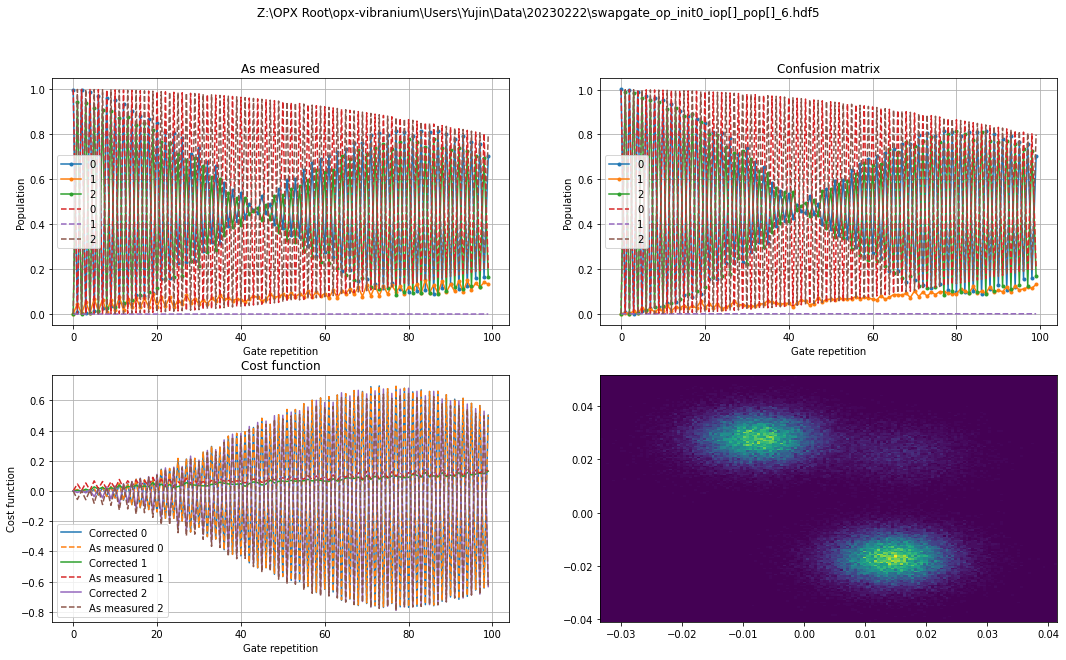

In [29]:
maxM = 100
Nshots = 1000
starting = 0
amp_opt = amp_opt_gate

path = gate_repetition(config, 'Yujin', gate_op=[name_op, 'andrew01'], amplitude=amp_opt, starting=0, post_op=[], maxM=maxM, Nshots=Nshots)
clear_output(wait=True)
diff = plot_gate_ops(path, maxM, Nshots, clf, correction=inv(cmat), mesolve=[True, [starting, *pulse_info]], display_num=None)

### From here, you can repeat some of the processes to fully optimize the gate. You might want to try different spectral filter weights when uploading the pulse.  